# Credible Concept Model (CCM) tutorial: extending credible model to uninterpretable raw features

By the end of the tutorial, one should be able to

1. understand the motivation of CCM
2. understand the CCM algorithm
3. able to train an CCM model

In [1]:
import numpy as np
import copy
import shap
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from lib.models import CCM, CBM, MLP, LambdaNet
from lib.train import train_step_standard, train_step_xyz, train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c
from lib.utils import dfs_freeze

# A motivating example

Despite the fact that model interpretation suffers from faithfulness and fragility issues (and also people's overtrust of the interpretation), it is still useful to enforce prior knowledge. Feature attribution tools often assume that features are interpretable. This makes them less applicable when raw features are complicated (say in the image or audio domain). Thus, a lot of recent research effort have been poured in to explanation with high level concepts. Among them is this idea of concept bottleneck network (CBM). In this work, we expose the flaw of CBM and suggest a simple fix. 

**We define EBM as CBM only using expert identified features as concepts**.

This examples shows why missing concept is a nastier problem than one would think.

$Z \sim U(\{0, 1\})^d$ are $d$ latent concepts

$X = project(Z)$ is a random linear projection of concepts presented to the human (the following just used identity for simplicity)

$X \rightarrow C \rightarrow X$ where $C \in \mathbb{R}^{d-1}$ is concept detectors

$Y = and(Z)$ where $\theta$ is the true coefficient.

This setup will fail raw feature attribution (because $X$ distribute concepts across dimensions), concept discovery (when the function is a "and" concept), jointly trained concept (because $C$ has 1 less dimension off $Z$).

In [2]:
n = 10000
d = 3 # true number of concepts needed for classification
c = 1 # number of expert identified concepts
bs = 100
n_epochs = 50

def gen_data(n, d):
    Z = np.random.choice([0, 1], (n, d))
    X = Z
    # and of the arguments
    Y = np.ones(n)
    for i in range(d):
        Y = np.logical_and(Y, Z[:, i])

    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(Z).float()

X, Y, Z = gen_data(n, d)
X_te, Y_te, Z_te = gen_data(n, d)
print(f'Percentage of ones {(1-0.5**d)*100:.2f}%')

Percentage of ones 87.50%


**Note that the above value ($1-1/2^d$) is also the theoretical limit the accuracy of EBM** because

\begin{align}
P(\hat{y} = y) &= P(Z_1=Z_2=\cdots=Z_c=1) P (\hat{y} = y | Z_1=Z_2=\cdots=Z_c=1) + P(\overline{Z_1=Z_2=\cdots=Z_c=1}) P(\hat{y} = y | \overline{Z_1=Z_2=\cdots=Z_c=1})\\
&= 1 / 2^c \cdot (1 - 1 / 2^{d-c}) + (1 - 1 / 2^c) \cdot 1\\
&= 1 - 1 / 2^d
\end{align}

In [3]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xyz = DataLoader(TensorDataset(X, Y, Z), batch_size=bs, shuffle=True) # joint concept and regular dataset

loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=True) # regular dataset
loader_xyz_te = DataLoader(TensorDataset(X_te, Y_te, Z_te), batch_size=bs, shuffle=True) # joint concept and regular dataset

## standard model

epoch   4: loss 2.825e-01
epoch   9: loss 1.110e-01
epoch  14: loss 5.102e-02
epoch  19: loss 2.641e-02
epoch  24: loss 1.500e-02
epoch  29: loss 9.123e-03
epoch  34: loss 5.836e-03
epoch  39: loss 3.875e-03
epoch  44: loss 2.642e-03
epoch  49: loss 1.840e-03


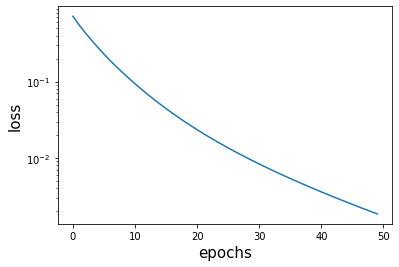

In [4]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, d * 2, 2])

    # train
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

standard_net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [5]:
print('task acc after training: {:.1f}%'.format(test(standard_net, loader_xy_te, acc_criterion) * 100))

task acc after training: 100.0%


## joint EBM

number of concepts to learn: 1
true number of concepts: 3
epoch   4: loss 9.408e-03
epoch   9: loss 5.399e-03
epoch  14: loss 3.040e-03
epoch  19: loss 2.267e-03
epoch  24: loss 1.821e-03
epoch  29: loss 1.428e-03
epoch  34: loss 1.094e-03
epoch  39: loss 8.317e-04
epoch  44: loss 6.326e-04
epoch  49: loss 4.834e-04


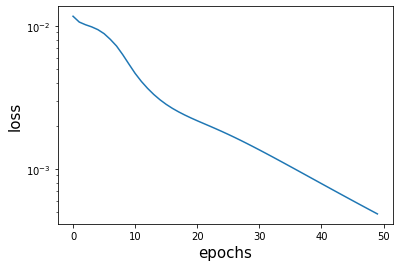

In [6]:
def joint_EBM(d, c, loader_xyz, n_epochs=10, report_every=1, plot=True):
    c = min(d, c)
    print(f'number of concepts to learn: {c}')
    print(f'true number of concepts: {d}')
    
    # EBM with concept and task jointly trained
    net_c = MLP([d, d * 2, c])
    net_y = MLP([c, d * 2, 2])
    net = CBM(net_c, net_y)
    
    # train
    def criterion(o_y, y, o_z, z):
        y_loss = F.cross_entropy(o_y, y).sum()
        z_loss = F.binary_cross_entropy(torch.sigmoid(o_z), z[:, :c]).sum()
        return (y_loss + z_loss) / len(y)
    
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xyz, opt, train_step=train_step_xyz, 
                criterion=criterion, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    
    return net

ebm_joint = joint_EBM(d, c, loader_xyz, n_epochs=n_epochs, report_every=n_epochs//10)

### TODO: the current setup only conciders concepts being binary, need to rewrite for multiclass concepts and regression concepts

In [7]:
def test_concept(net, concept_idx, loader):
    '''net output many logit for concepts, concept_idx is the concept index'''
    net.eval()
    losses = []
    total = 0
    for x, y in loader:
        o = net(x) # (bs, c)
        o2 = torch.sigmoid(o[:, concept_idx]) > 0.5
        l = (o2 == y).float().mean()
        bs = o.shape[0]
        total += bs        
        losses.append(l.detach().item() * bs)
    net.train()
    return sum(losses) / total

def print_concept_acc(net_c, c, X_te, Z_te):
    for i in range(c):
        print('concept {} acc after training: {:.1f}%'.format(i, test_concept(net_c,
                                                                              i,
                                                                              DataLoader(TensorDataset(X_te, Z_te[:, i]), batch_size=bs)) * 100))

print('task acc after training: {:.1f}%'.format(test(ebm_joint, loader_xy_te, acc_criterion ) * 100))
print_concept_acc(ebm_joint.net_c, c, X_te, Z_te)

task acc after training: 100.0%
concept 0 acc after training: 100.0%


**Note Jointly trained EBM has accuracy above the thoretical limit of ($1 - 2^d$) without sacrificing concept accuracy. This is why it is wrong!**

## independent EBM

number of concepts to learn: 1
true number of concepts: 3
training concepts ...
epoch   4: loss 3.727e-01
epoch   9: loss 1.003e-01
epoch  14: loss 3.370e-02
epoch  19: loss 1.482e-02
epoch  24: loss 7.739e-03
epoch  29: loss 4.494e-03
epoch  34: loss 2.797e-03
epoch  39: loss 1.824e-03
epoch  44: loss 1.230e-03
epoch  49: loss 8.497e-04
training tasks ...
epoch   4: loss 3.839e-01
epoch   9: loss 3.027e-01
epoch  14: loss 2.879e-01
epoch  19: loss 2.840e-01
epoch  24: loss 2.824e-01
epoch  29: loss 2.817e-01
epoch  34: loss 2.812e-01
epoch  39: loss 2.809e-01
epoch  44: loss 2.808e-01
epoch  49: loss 2.807e-01


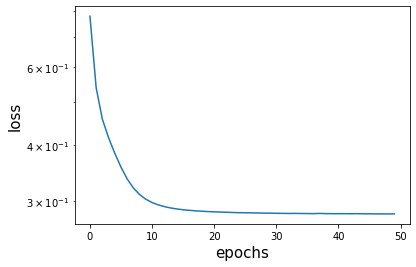

In [8]:
def ind_EBM(d, c, X, Y, Z, n_epochs=10, report_every=1, plot=True):
    c = min(d, c)
    print(f'number of concepts to learn: {c}')
    print(f'true number of concepts: {d}')
    
    # EBM with concept and task independently trained
    net_c = nn.Sequential(MLP([d, d * 2, c]), nn.Sigmoid())
    net_y = MLP([c, d * 2, 2])
    net = CBM(net_c, net_y)
    
    # train
    print('training concepts ...')
    opt_c = optim.Adam(net_c.parameters())
    train(net_c, 
          DataLoader(TensorDataset(X, Z[:, :c]), batch_size=bs, shuffle=True), 
          opt_c, criterion=nn.BCELoss(), n_epochs=n_epochs, report_every=report_every)

    print('training tasks ...')
    opt_y = optim.Adam(net_y.parameters())
    log = train(net_y, 
                DataLoader(TensorDataset(Z[:, :c], Y), batch_size=bs, shuffle=True), 
                opt_y, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)

    return net

ebm_ind = ind_EBM(d, c, X, Y, Z, n_epochs=n_epochs, report_every=n_epochs//10)

In [9]:
print('task acc after training: {:.2f}%'.format(test(ebm_ind, loader_xy_te, acc_criterion ) * 100)) # the optimum is 1/16 + 3/4; the strategy is to randomize if the first concept is 1, otherwise output 0
print_concept_acc(ebm_ind.net_c[0], c, X_te, Z_te) # net_c[0] because it is the logit part

task acc after training: 87.08%
concept 0 acc after training: 100.0%


## Concept completeness

Since concept can overload in joint EBM, concept completeness measure would only help if we can understand what concept it is using, which defeats the purpose of using high level feature.

In [10]:
# generate all possible input
explain_X = []
for i in range(2**d):
    item = np.zeros(d)
    idx = 0
    while i != 0:
        idx += 1
        item[-idx] = i % 2
        i = i // 2
    explain_X.append(item)
explain_X = torch.from_numpy(np.array(explain_X)).float()
shap_x = pd.DataFrame(explain_X.numpy(), columns=[f'X{i}' for i in range(d)])
shap_x

,X0,X1,X2
0,0.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,1.0,1.0
4,1.0,0.0,0.0
5,1.0,0.0,1.0
6,1.0,1.0,0.0
7,1.0,1.0,1.0


    X0   X1   X2  logit Z0
3  0.0  1.0  1.0     -5.97
1  0.0  0.0  1.0     -4.87
2  0.0  1.0  0.0     -4.87
0  0.0  0.0  0.0     -3.83
7  1.0  1.0  1.0      1.81
4  1.0  0.0  0.0      2.89
5  1.0  0.0  1.0      2.89
6  1.0  1.0  0.0      2.89
Explaining logit Z0


  0%|          | 0/8 [00:00<?, ?it/s]

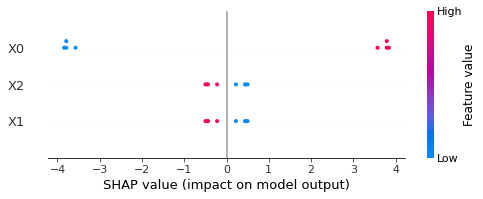

In [11]:
shap_net_x(ebm_joint.net_c, shap_x, bs, output_name="logit Z")

    X0   X1   X2  logit Z0
3  0.0  1.0  1.0     -7.57
2  0.0  1.0  0.0     -7.11
1  0.0  0.0  1.0     -7.07
0  0.0  0.0  0.0     -6.61
4  1.0  0.0  0.0      6.81
7  1.0  1.0  1.0      7.06
6  1.0  1.0  0.0      7.52
5  1.0  0.0  1.0      7.57
Explaining logit Z0


  0%|          | 0/8 [00:00<?, ?it/s]

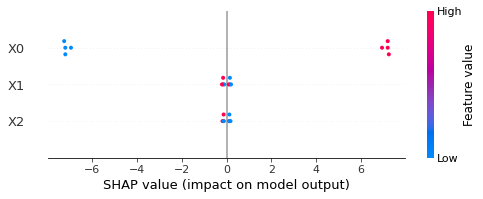

In [12]:
shap_net_x(LambdaNet(lambda x: ebm_ind.net_c[0](x)), shap_x, bs, output_name="logit Z")

It's very hard to tell whether the concept detector is overloaded as it is clearly more dependent on the first concept.

### TODO: run this example with Yeh et al's measure and its interpretable model

In fact we can even analytically define the concept vector as $[1, -0.1, -0.1]$. This clearly would prefer concept 0 in order to activate. However, it still gives away information about both concept 1 and concept 2.


## TODO: EBM sequential

EBM sequential don't need concept dataset and the classification task to overlap, which is way more flexible. The lesson is we should not jointly train interpretable models: this would transfer to CCM.

## CCM residue

It would fail because we know the impact should be the same for $Z_0$ and $Z_1$ and $Z_2$, but we would have observed $Z_0$ have less impact.

number of concepts to learn: 1
true number of concepts: 3
epoch   4: loss 1.989e-01
epoch   9: loss 1.131e-01
epoch  14: loss 6.481e-02
epoch  19: loss 4.045e-02
epoch  24: loss 2.708e-02
epoch  29: loss 1.863e-02
epoch  34: loss 1.323e-02
epoch  39: loss 9.570e-03
epoch  44: loss 7.015e-03
epoch  49: loss 5.192e-03


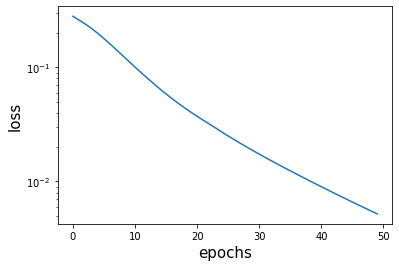

In [13]:
def res_CCM(ebm, d, c, X, Y, n_epochs=10, report_every=1, bs=100, plot=True):
    '''
    residue CCM: net_y adds ebm(x) and cbm_res(x)
    where cbm_res is cbm with not interpretable concepts
    '''
    c = min(d, c)
    print(f'number of concepts to learn: {c}')
    print(f'true number of concepts: {d}')

    # freeze ebm (don't require grad) so that it does not train
    ebm.eval()
    dfs_freeze(ebm)

    # additional channel to fit residue
    # classification problem: pure residue does not work b/c y is not continous (cannot test acc)
    # we need to fit to the logit
    cbm_res = CBM(LambdaNet(lambda x: x), MLP([d, d * 2, 2]))
    net_y = LambdaNet(lambda c, not_c: ebm.net_y(c) + cbm_res.net_y(not_c))
    net = CCM(ebm.net_c, cbm_res.net_c, net_y)

    # train
    opt = optim.Adam(cbm_res.parameters())
    log = train(net, 
                DataLoader(TensorDataset(X, Y), batch_size=bs), 
                opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net
    
ccm_res = res_CCM(copy.deepcopy(ebm_ind), d, c, X, Y, n_epochs=n_epochs, report_every=n_epochs//10)

In [14]:
print('task acc after training: {:.2f}%'.format(test(ccm_res, loader_xy_te, acc_criterion ) * 100))

task acc after training: 100.00%


    X0   X1   X2  hat Y0  hat Y1
7  1.0  1.0  1.0    0.03    0.97
0  0.0  0.0  0.0    1.00    0.00
1  0.0  0.0  1.0    1.00    0.00
2  0.0  1.0  0.0    1.00    0.00
3  0.0  1.0  1.0    1.00    0.00
4  1.0  0.0  0.0    1.00    0.00
5  1.0  0.0  1.0    1.00    0.00
6  1.0  1.0  0.0    1.00    0.00
Explaining hat Y1


  0%|          | 0/8 [00:00<?, ?it/s]

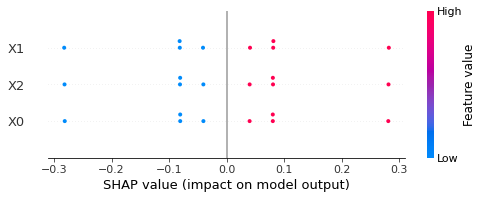

In [15]:
shap_net_x(nn.Sequential(ccm_res, nn.Softmax(dim=1)), shap_x, bs, output_name="hat Y", output_idx=1)

They seem very symmetrical in the input space. However, if we focus on concept attribution:

    Z0   X0   X1   X2  hat Y0  hat Y1
7  1.0  1.0  1.0  1.0    0.03    0.97
0  0.0  0.0  0.0  0.0    1.00    0.00
1  0.0  0.0  0.0  1.0    1.00    0.00
2  0.0  0.0  1.0  0.0    1.00    0.00
3  0.0  0.0  1.0  1.0    1.00    0.00
4  1.0  1.0  0.0  0.0    1.00    0.00
5  1.0  1.0  0.0  1.0    1.00    0.00
6  1.0  1.0  1.0  0.0    1.00    0.00
Explaining hat Y1


  0%|          | 0/8 [00:00<?, ?it/s]

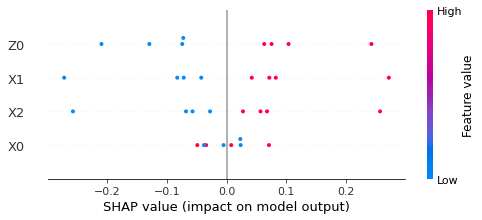

In [16]:
shap_ccm_c(ccm_res, shap_x, bs, not_c_name='X', output_idx=1) # not_c_name is input b/c I used identity for ccm.not_c

**Z's influence is divided by X: the model recompute concepts from scratch**

number of concepts to learn: 1
true number of concepts: 3
   logit Z0   X0   X1   X2  hat Y0  hat Y1
7      1.81  1.0  1.0  1.0    0.01    0.99
0     -3.83  0.0  0.0  0.0    1.00    0.00
1     -4.87  0.0  0.0  1.0    1.00    0.00
2     -4.87  0.0  1.0  0.0    1.00    0.00
3     -5.97  0.0  1.0  1.0    1.00    0.00
4      2.89  1.0  0.0  0.0    1.00    0.00
5      2.89  1.0  0.0  1.0    1.00    0.00
6      2.89  1.0  1.0  0.0    1.00    0.00
Explaining hat Y1


  0%|          | 0/8 [00:00<?, ?it/s]

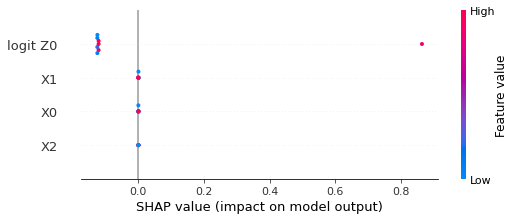

In [17]:
ccm_res_joint = res_CCM(copy.deepcopy(ebm_joint), d, c, X, Y, n_epochs=0, report_every=1, plot=False) #n_epochs//10)
shap_ccm_c(ccm_res_joint, shap_x, bs, not_c_name='X', output_idx=1, c_name='logit Z')

The above graph sanity checks that joint EBM based residue CCM does not use raw input

## TODO: CCM EYE